# **Model data processing for Black Sea flooding study**

In [1]:
import sys; sys.path.append('../'); from wwa import *
cproj = cartopy.crs.PlateCarree()

xn, xx, yn, yx = [25,41.5,40,50]
Xn, Xx, Yn, Yx = [20,60,35,55]

synda_path = "/rds/general/project/wwa/ephemeral/sfcWind/synda/data/"
tmp_path = "/rds/general/project/wwa/ephemeral/sfcWind/tmp/"

In [2]:
from taylorDiagram import TaylorDiagram, taylor_scores

# plotting parameters
gcm_markers = {'CNRM-CM5_r1i1p1'     : 'o',
                  'EC-EARTH_r12i1p1'    : 'p',
                  'EC-EARTH_r1i1p1'     : 'h',
                  'EC-EARTH_r3i1p1'     : 'H',
                  'IPSL-CM5A-MR_r1i1p1' : "s",
                  'HadGEM2-ES_r1i1p1'   : 'P',
                  'MPI-ESM-LR_r1i1p1'   : '^',
                  'MPI-ESM-LR_r2i1p1'   : '<',
                  'MPI-ESM-LR_r3i1p1'   : '>',
                  'NorESM1-M_r1i1p1'    : 'X',}

rcm_colours = {'ALADIN63'          : 'mediumblue',
               'ALARO-0'           : 'violet',
               'CCLM4-8-17'        : 'blueviolet',
               'COSMO-crCLIM-v1-1' : 'mediumvioletred',
               'HIRHAM5'           : 'red',
               'HadREM3-GA7-05'    : 'darkorange',
               'RACMO22E'          : 'gold',
               'RCA4'              : 'yellowgreen',
               'REMO2015'          : 'green',
               'REMO2009'          : 'green',
               'RegCM4-6'          : 'darkturquoise',
               'WRF381P'           : 'dodgerblue'}

gcm_handles = [matplotlib.lines.Line2D([], [], color = "w", marker = m, markersize = 6, markeredgecolor = "black", linestyle = "None") for gcm_nm, m in gcm_markers.items()]
rcm_handles = [matplotlib.lines.Line2D([], [], color = c, marker = 'o', markersize = 6, markeredgecolor = "black", linestyle = "None") for rcm_nm, c in rcm_colours.items()]

---
# **CORDEX sfcWind data**

## **Cut out smaller region**

In [7]:
# filter out any models that don't have both historical & rcp85
model_list = sorted(glob.glob(synda_path+"*/*/*"))
model_list = [fp for fp in model_list if (len(glob.glob(fp+"/sfcWind/*rcp85*.nc")) > 0) and (len(glob.glob(fp+"/sfcWind/*hist*.nc")) > 0)]

In [ ]:
for fp in model_list:
    print("_".join(fp.split("/")[-3:]))
    
    fl = glob.glob(fp+"/sfcWind/*.nc")
    for fnm in fl:
        
        if os.path.exists(tmp_path+fnm.split("/")[-1]): continue
        da = xr.open_dataset(fnm)
        
        if "longitude" in da.coords: da = da.rename(longitude = "lon", latitude = "lat")
        
        if "rlon" in da.dims:
            xdim, ydim = ["rlat", "rlon"]
        elif "x" in da.dims:
            xdim, ydim = ["x", "y"]
        else:
            print(da.dims)
            continue
            
        # some files have wrong coordinate metadata...
        if not "lon" in da.coords:
            if "lon" in da.data_vars:
                da = da.assign_coords(lon = da.isel(time = 0, drop = True).lon, 
                                      lat = da.isel(time = 0, drop = True).lat)
            else:
                if not "_".join(fp.split("/")[-3:]) in coord_path.keys(): 
                    print("_".join(fp.split("/")[-3:])+" needs coordinates")
                    continue
                else:
                    # copy coordinates & dims from a file that does have them
                    cpath = coord_path["_".join(fp.split("/")[-3:])]
                    cpath = glob.glob(re.sub("rcp85", "*", re.sub("historical", "*", re.sub("[0-9]{8}-[0-9]{8}.nc", cpath, fnm))))[0]
                    tmplt = xr.open_dataset(cpath)
                    da = da.assign_coords({xdim : tmplt[xdim], ydim : tmplt[ydim], "lon" : tmplt.lon, "lat" : tmplt.lat})
                
        # select just the study region
        rm = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
        rm = rm.where(rm == 1).dropna(xdim, "all").dropna(ydim, "all")
        da = da.sel({xdim : rm[xdim], ydim : rm[ydim]}).sfcWind
        
        # clean up unwanted extra coordinates
        if "height" in da.coords: da.reset_coords("height", drop = True)
        
        da.to_netcdf(tmp_path+fnm.split("/")[-1])

## **Extract daily time series & spatial pattern**

In [27]:
model_list = sorted(list(set([re.sub("historical", "rcp85", "_".join(fnm.split("_")[2:7])) for fnm in glob.glob(tmp_path+"*")])))

In [28]:
abridge_gcm = {"CNRM-CERFACS-CNRM-CM5" : "CNRM-CM5",
               "ICHEC-EC-EARTH" : "EC-EARTH",
               'IPSL-IPSL-CM5A-LR' : 'IPSL-CM5A-LR',
               'IPSL-IPSL-CM5A-MR' : 'IPSL-CM5A-MR',
               'MOHC-HadGEM2-ES' : 'HadGEM2-ES',
               'MPI-M-MPI-ESM-LR' : 'MPI-ESM-LR',
               'NCC-NorESM1-M' : 'NorESM1-M',
               'NOAA-GFDL-GFDL-ESM2G' : 'GFDL-ESM2G'}

abridge_rcm = {'CLMcom-CCLM4-8-17': "CCLM4-8-17",
                 'CLMcom-ETH-COSMO-crCLIM-v1-1': "COSMO-crCLIM-v1-1",
                 'CNRM-ALADIN63':"ALADIN63",
                 'DMI-HIRHAM5':"HIRHAM5",
                 'GERICS-REMO2015':"REMO2015",
                 'ICTP-RegCM4-6':"RegCM4-6",
                 'IPSL-WRF381P':"WRF381P",
                 'KNMI-RACMO22E':"RACMO22E",
                 'MOHC-HadREM3-GA7-05':"HadREM3-GA7-05",
                 'MPI-CSC-REMO2009':"REMO2009",
                 'SMHI-RCA4':"RCA4",
                 'UHOH-WRF361H':"WRF361H"}

In [ ]:
for mdl in model_list:
    
    print(mdl)
    
    if mdl in ["MOHC-HadGEM2-ES_rcp85_r1i1p1_ICTP-RegCM4-6_v1"]: continue
    
    # get neater filename
    mdl_fixed = [re.sub(k, v, mdl) for k, v in abridge_gcm.items() if k in mdl][0]
    mdl_fixed = [re.sub(k, v, mdl_fixed) for k, v in abridge_rcm.items() if k in mdl_fixed][0]
    
    sp_fnm = "/rds/general/project/wwa/ephemeral/sfcWind/spatial/sfcWind-spatial_EUR-11_"+mdl_fixed+".nc"
    ts_fnm = "/rds/general/project/wwa/ephemeral/sfcWind/daily/sfcWind-daily_EUR-11_"+mdl_fixed+".nc"
    
    if os.path.exists(sp_fnm) and os.path.exists(ts_fnm): continue
    
    ds = xr.open_mfdataset(glob.glob(tmp_path+"*"+re.sub("rcp85", "*", mdl+"*.nc")))
    
    # repair coordinates that I accidentally demoted to variables in some runs
    if "lon" in ds.data_vars: ds = ds.assign_coords(lon = ds.lon.isel(time = 0, drop = True), 
                                                    lat = ds.lat.isel(time = 0, drop = True))
    ds = ds.sfcWind
        
    # for spatial evaluation, just get the monthly means
    ds.sel(time = slice("1980", "2010")).groupby("time.month").mean().to_netcdf(sp_fnm)
    
    # and get time series over study region
    rm = np.logical_and(np.logical_and(ds.lon >= xn, ds.lon <= xx), np.logical_and(ds.lat >= yn, ds.lat <= yx))
#     lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds.lon, ds.lat)
    ds_incl = ds.where((rm == 1))# & (lsm == 0))
    
    if "rlat" in ds_incl.dims:
        ts = ds_incl.mean(["rlat","rlon"])
    elif "x" in ds_incl.dims:
        ts = ds_incl.mean(["x","y"])
        
    ts.to_netcdf(ts_fnm)

CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-ETH-COSMO-crCLIM-v1-1_v1
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CNRM-ALADIN63_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_DMI-HIRHAM5_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_GERICS-REMO2015_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_ICTP-RegCM4-6_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_IPSL-WRF381P_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_KNMI-RACMO22E_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_MOHC-HadREM3-GA7-05_v2
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_CLMcom-CCLM4-8-17_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_CLMcom-ETH-COSMO-crCLIM-v1-1_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_DMI-HIRHAM5_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_ICTP-RegCM4-6_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_IPSL-WRF381P_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_KNMI-RACMO22E_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_MOHC-HadREM3-GA7-05_v1
ICHEC-EC-EARTH_rcp85_r12i1p1_SMHI-RCA4_v1
ICHEC-EC-EARTH_rcp85_r1i1p1_CLMcom-ETH-COSMO-crCLIM-v1-1_v1
ICHEC-EC-EARTH

## **Create time series of 3-day maxima for climate explorer**

In [34]:
for fnm in glob.glob("/rds/general/project/wwa/ephemeral/sfcWind/daily/*.nc"):
    
    mdl = re.sub("v1-1", "", re.sub("i1p1", "", re.sub("_rcp85", "", "_".join(fnm.split("_")[1:-1]))))
    
    ts = xr.open_dataset(fnm).sfcWind.rolling(time = 3).mean().resample(time = "AS-JUL").max()
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
    ts = convert_units_to(ts, "m/s")
    
    csv_fnm = "blacksea-floods_wsx3day_"+mdl
    csv_fullpath = "/rds/general/project/wwa/ephemeral/sfcWind/ts/"+csv_fnm+".dat"
    
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CORDEX "+mdl+" wsx3day - Black Sea flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# wsx3day [m/s] annual (Jul-Jun) maximum of 3-day mean wind speeds averaged over Black Sea region at "+csv_fnm
    head = "# year wsx3day"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_dataframe().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

# **Seasonal cycle & spatial patterns**

In [ ]:
# # Compute seasonal cycle & spatial pattern from ERA5, save for later use (originally run on CLimate Explorer)

# era5 = xr.open_dataset("era5_windspeed.nc")["__xarray_dataarray_variable__"].rename("windspeed")
# era5 = wrap_lon(era5.sel(time = slice("1980", "2010")).resample(time = "D").mean())

# era5_sp = era5.mean("time").rename(longitude = "lon", latitude = "lat")
# era5_sp.to_netcdf("era5_windspeed_spatial.nc")

# era5 = era5.sel(longitude = slice(xn, xx), latitude = slice(yn, yx)).mean(["latitude", "longitude"])
# era5_sc = era5.groupby("time.dayofyear").mean()

# era5_sc.to_netcdf("era5_windspeed_seasonal.nc")

## **Seasonal cycle**

### **Compute seasonal cycles**

In [7]:
# load model data & compute seasonal cycle - windspeed
fl = glob.glob("daily/sfcWind*EUR-11*")

cordex =  [xr.open_dataset(fnm).sel(time = slice("1980", "2010")).sfcWind.expand_dims(run = ["_".join(fnm.split("_")[2:6])]) for fnm in fl]
cordex = [r.assign_coords(time = r.time.dt.floor("D")) for r in cordex]
cordex = [convert_calendar(r,  "default", align_on = "year") for r in cordex]
cordex = xr.concat(cordex, "run", coords = "minimal").reset_coords("height", drop = True)

cordex_sc = cordex.groupby("time.dayofyear").mean().rename("windspeed")
cordex_sc.to_netcdf("cordex_windspeed_seasonal.nc")

In [8]:
# load model data & compute seasonal cycle - precip
fl = glob.glob("daily/pr3day*EUR-11*")

cordex =  [xr.open_dataset(fnm).sel(time = slice("1980", "2010")).pr.expand_dims(run = ["_".join(fnm.split("_")[2:6])]) for fnm in fl]
cordex = [r.assign_coords(time = r.time.dt.floor("D")) for r in cordex]
cordex = [convert_calendar(r,  "default", align_on = "year") for r in cordex]
cordex = xr.concat(cordex, "run", coords = "minimal")

cordex_sc = cordex.groupby("time.dayofyear").mean().rename("precip")
cordex_sc.to_netcdf("cordex_precip_seasonal.nc")

### **Taylor diagram - wind**

In [3]:
varnm = "windspeed"

# get scores for Taylor diagram
era5_sc = xr.open_dataset("era5_"+varnm+"_seasonal.nc")[varnm]
cordex_sc = xr.open_dataset("cordex_"+varnm+"_seasonal.nc")[varnm]

if varnm == "precip": cordex_sc = cordex_sc.sel(run = [not "WRF361H" in rnm for rnm in cordex_sc.run.values]) * 86400

In [4]:
corrs, sds, ref_sd = taylor_scores(cordex_sc, era5_sc)

max_sd = 3.5 #max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

# evaluate the model based on the scores
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex_sc.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "windspeed":
    td_df.loc[td_df.sd >= ref_sd * 2,"eval"] = "bad"
    td_df.loc[td_df.sd < ref_sd * 2,"eval"] = "good"
    
td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_seasonal-scores.csv")

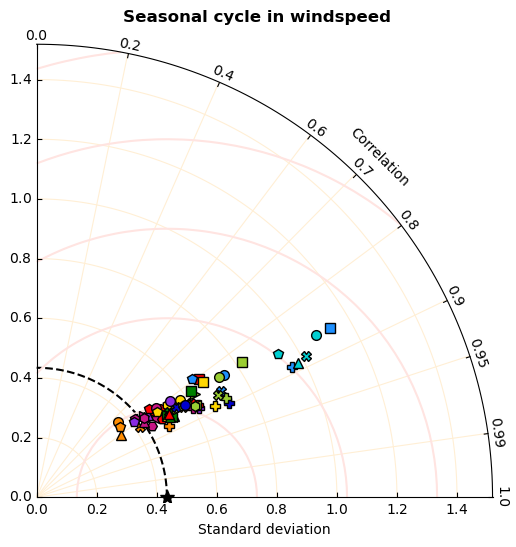

In [5]:
# make Taylor diagram

fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = re.sub(".nc", "", cordex_sc.run.values[i])
    gcm_marker = gcm_markers[mdl.split("_")[0]+"_"+mdl.split("_")[2]]
    rcm_colour = rcm_colours[mdl.split("_")[3]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in "+varnm, fontweight = "bold", y = 0.93)

plt.savefig("fig/taylor-diagram_"+varnm+"_seasonal-cycle.png")

### **Taylor diagram - precip**
Had to produce separately due to negative correlations in precip

In [150]:
varnm = "precip"

# get scores for Taylor diagram
era5_sc = xr.open_dataset("era5_"+varnm+"_seasonal.nc")[varnm]
cordex_sc = xr.open_dataset("cordex_"+varnm+"_seasonal.nc")[varnm]

if varnm == "precip": cordex_sc = cordex_sc.sel(run = [not "WRF361H" in rnm for rnm in cordex_sc.run.values]) * 86400

In [151]:
corrs, sds, ref_sd = taylor_scores(cordex_sc, era5_sc)

max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

# evaluate the model based on the scores
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex_sc.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "windspeed":
    td_df.loc[td_df.sd >= ref_sd * 2,"eval"] = "bad"
    td_df.loc[td_df.sd < ref_sd * 2,"eval"] = "good"
elif varnm == "precip":
    td_df.loc[(td_df.cor < 0.25),"eval"] = "bad"
    td_df.loc[(td_df.cor > 0.25),"eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.5) & (td_df.sd <= ref_sd * 2),"eval"] = "good"
    
td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_seasonal-scores.csv")

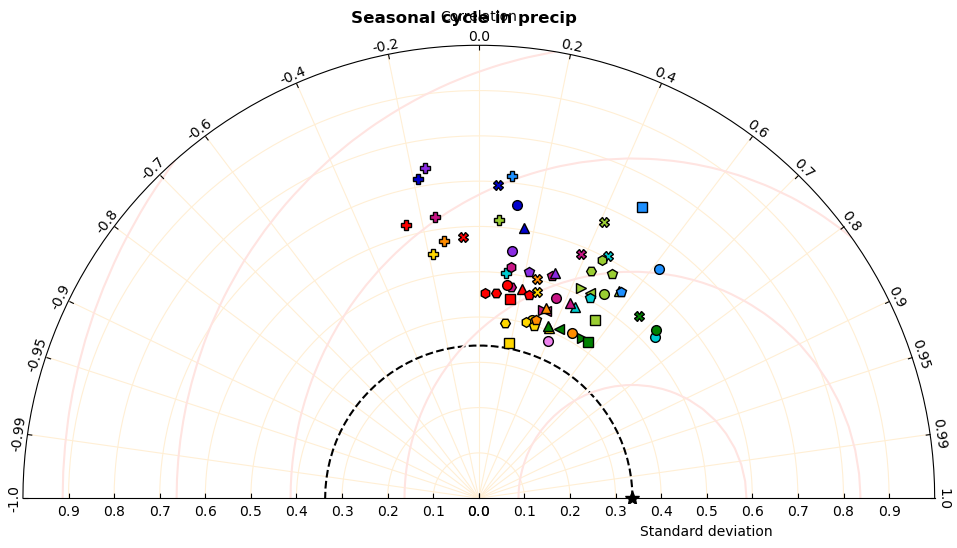

In [36]:
# make Taylor diagram

fig = plt.figure(figsize = (12,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = True)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = re.sub(".nc", "", cordex_sc.run.values[i])
    gcm_marker = gcm_markers[mdl.split("_")[0]+"_"+mdl.split("_")[2]]
    rcm_colour = rcm_colours[mdl.split("_")[3]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in "+varnm, fontweight = "bold", y = 0.93)

plt.savefig("fig/taylor-diagram_"+varnm+"_seasonal-cycle.png")

### **Visual check**

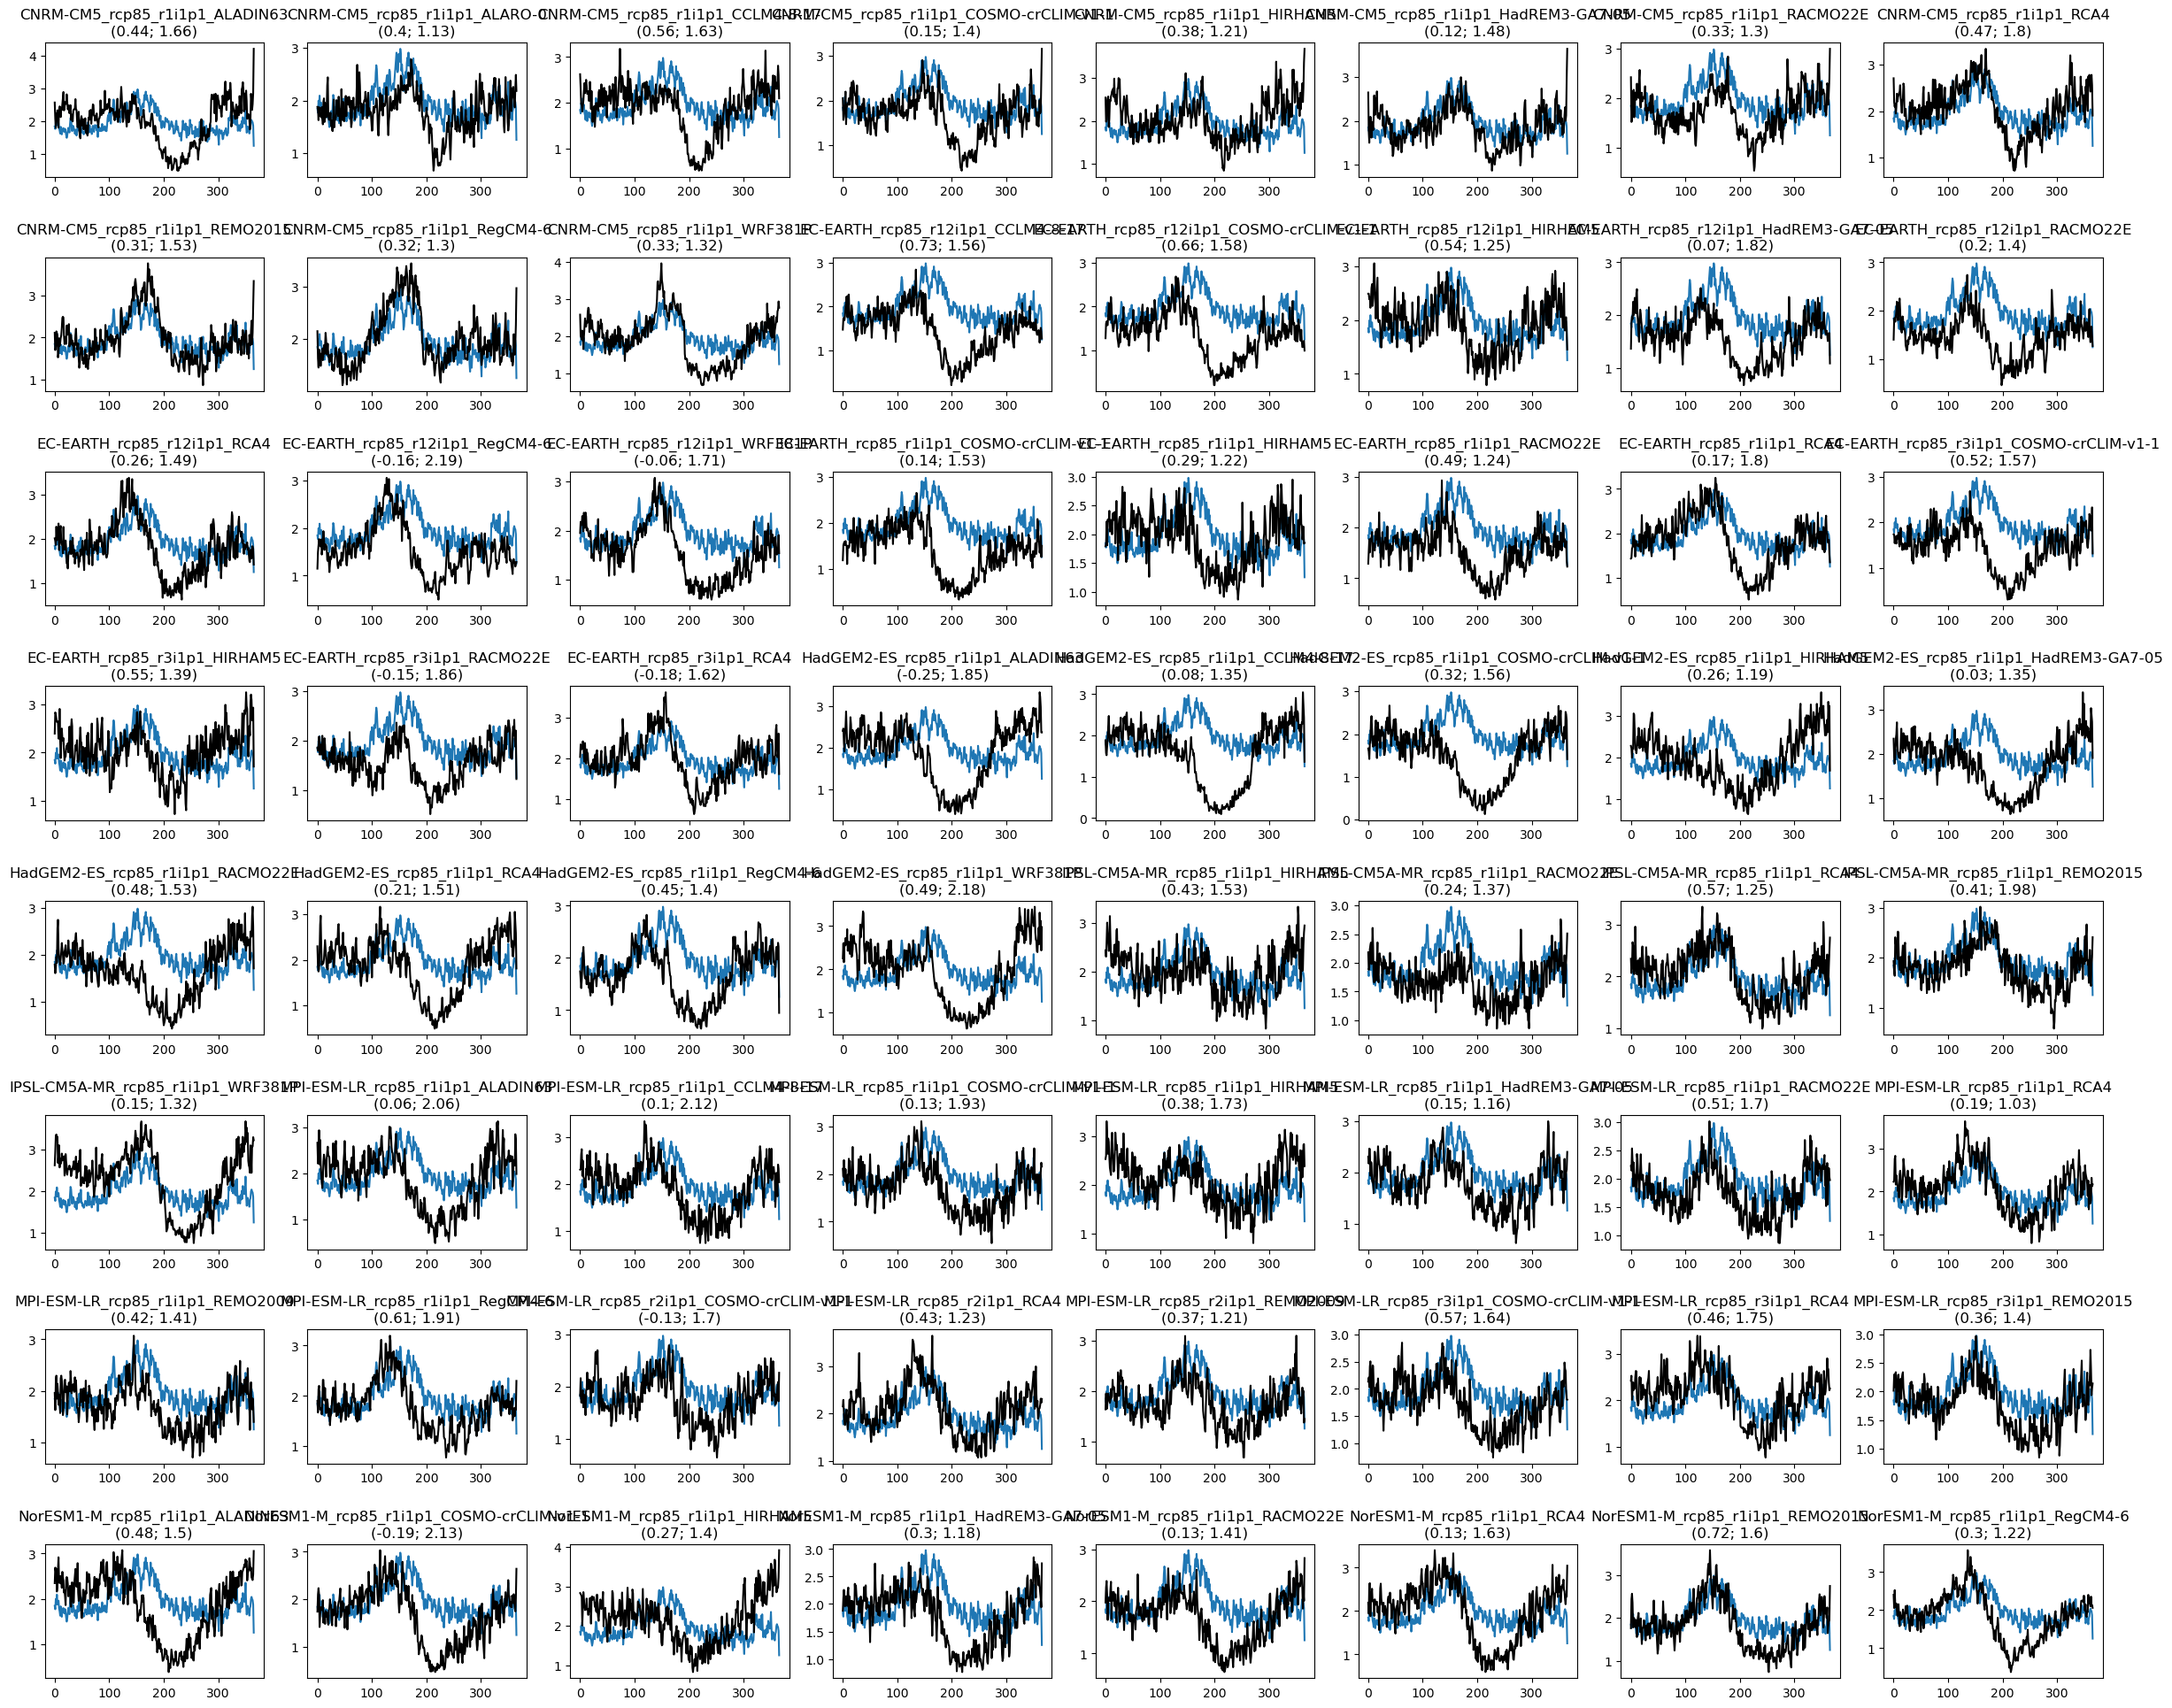

In [157]:
fig, axs = plt.subplots(ncols = 8, nrows = 8, figsize = (30,24), dpi = 100)
plt.subplots_adjust(hspace = 0.6)

cordex_sc = cordex_sc.sortby(cordex_sc.run)

for i in range(64):
    ax = fig.axes[i]
    mdl = re.sub(".nc", "", cordex_sc.run.values[i])
    
    ax.plot(era5_sc, color = "tab:blue")
    ax.plot(cordex_sc.isel(run = i), color = "k")
    
    ax.set_title(mdl+"\n("+str(round(corrs[i], 2))+"; "+str(round(sds[i] / ref_sd, 2))+")")
    
plt.savefig("fig/precip-seasonal-cycles.png")

## **Spatial pattern**

### **Regrid models**

In [3]:
# methods for regridding
import xesmf as xe
warnings.filterwarnings("ignore", message = ".+F_CONTIGUOUS.+")

def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]
    

def vertices_from_centres(x_coords, y_coords, crs_in = None, crs_out = None):
    
    # Compute vertices on regular grid of 1d x, y coordinates
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    # compute offsets needed to find midpoints
    x_offset = np.diff(x_coords) / 2
    y_offset = np.diff(y_coords) / 2
    
    # use offsets to obtain vectors of cell midpoints (adds 1 to each dimension)
    x_bounds = xr.concat([x_coords[0] - x_offset[0], x_coords[:-1] + x_offset, x_coords[-1] + x_offset[-1]], dim = x_coords.dims[0])
    y_bounds = xr.concat([y_coords[0] - y_offset[0], y_coords[:-1] + y_offset, y_coords[-1] + y_offset[-1]], dim = y_coords.dims[0])
    
    # expand vectors of bounds to grid of corners (& transform projection if necessary)
    xvert, yvert = transform_xy(x_bounds, y_bounds, crs_in = crs_in, crs_out = crs_out)
    
    return(xvert, yvert)


def add_grid(da, x_coords, y_coords, crs_in = None, crs_out = None):
    
    # return grid with vertices based on regular grid of 1d x, y coordinates, to be used in regridding using xe.Regridder
    if type(x_coords) == str: x_coords = da[x_coords]
    if type(y_coords) == str: y_coords = da[y_coords]
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    lon, lat = transform_xy(x_coords, y_coords, crs_in, crs_out)
    lon_b, lat_b = vertices_from_centres(x_coords, y_coords, crs_in, crs_out)
    
    da = da.assign_coords(lon = ([y_coords.name, x_coords.name], lon, x_coords.attrs), lat = ([y_coords.name, x_coords.name], lat, y_coords.attrs),
                          lon_b = ([y_coords.name+"_b", x_coords.name+"_b"], lon_b), lat_b = ([y_coords.name+"_b", x_coords.name+"_b"], lat_b))
    
    return da

In [4]:
import cartopy.crs as ccrs
cordex_crs = {"ALADIN63"          : ccrs.LambertConformal(central_longitude = 10.5, central_latitude = 49.5, standard_parallels = [49.5,]),
              "ALARO-0"           : ccrs.LambertConformal(central_longitude = 9.9, central_latitude = 49.0, standard_parallels = [49.0,]),
              "COSMO-crCLIM-v1-1" : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "HIRHAM5"           : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "HadREM3-GA7-05"    : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "RCA4"              : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "RACMO22E"          : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "REMO2009"          : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "REMO2015"          : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "RegCM4-6"          : ccrs.LambertConformal(central_longitude = 9.75, central_latitude = 48.0, standard_parallels = [30., 65.],
                                                          false_easting = -6000, false_northing = -6000, 
                                                          globe = ccrs.Globe(semimajor_axis = 6371229.0, inverse_flattening = None)),
              "CCLM4-8-17"        : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "WRF361H"           : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25),
              "WRF381P"           : ccrs.RotatedPole(pole_longitude = -162.0, pole_latitude = 39.25)}

era5_crs = cartopy.crs.PlateCarree()

In [5]:
# load ERA5, add grid for easier regridding
era5_sp = xr.open_dataset("era5_precip_spatial.nc")

lonvert, latvert = vertices_from_centres(era5_sp.lon, era5_sp.lat)
era5_sp["lon_b"] = (["latb", "lonb"], lonvert)
era5_sp["lat_b"] = (["latb", "lonb"], latvert)

In [6]:
# build separate regridder for ALADIN63
aladin = xr.open_dataset("aladin63_bounds.nc")

aladin_lon_b = xr.concat([xr.concat([aladin.bounds_lon.isel(x = 0, nvertex = 0), aladin.bounds_lon.isel(nvertex = 1)], "x"),
                          xr.concat([aladin.bounds_lon.isel(y = -1, x = 0, nvertex = 2), aladin.bounds_lon.isel(y = -1, nvertex = 2)], "x")], "y")

aladin_lat_b = xr.concat([xr.concat([aladin.bounds_lat.isel(x = 0, nvertex = 0), aladin.bounds_lat.isel(nvertex = 1)], "x"),
                          xr.concat([aladin.bounds_lat.isel(y = -1, x = 0, nvertex = 2), aladin.bounds_lat.isel(y = -1, nvertex = 2)], "x")], "y")

aladin = aladin.assign_coords(lon_b = (["y_b", "x_b"], aladin_lon_b.values), lat_b = (["y_b", "x_b"], aladin_lat_b.values), lon = aladin.lon, lat = aladin.lat).reset_coords(["bounds_lon", "bounds_lat"], drop = True)

rg_aladin = xe.Regridder(aladin, era5_sp, method = "conservative_normed", unmapped_to_nan = True)

In [7]:
# regridding fails on ALADIN63 - need to look into this
fl = glob.glob("spatial/pr3day*EUR-11*.nc")

regridded_cordex = []
for fnm in fl:
    
    # print(fnm)
    if "WRF361H" in fnm or "ALARO" in fnm: continue # seems to only have future runs
    ds = xr.open_dataset(fnm)
    mdl_crs = cordex_crs[re.sub(".nc", "", fnm.split("_")[-1])]
    mdl = re.sub(".nc", "", re.sub("_rcp85", "", "_".join(fnm.split("_")[-4:])))
    
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    
    if "ALADIN63" in fnm:
        ds = ds.assign_coords(lon = ds.lon, lat = ds.lat)
        regridded = rg_aladin(xr.concat([aladin, ds], "new").isel(new = -1).pr).reset_coords(drop = True).squeeze().expand_dims(run = [mdl])
    else:
        if "rlon" in ds.dims:
            ds = add_grid(ds, ds.rlon, ds.rlat, crs_in = mdl_crs, crs_out = era5_crs)
        else:
            ds = add_grid(ds, ds.x, ds.y, crs_in = mdl_crs, crs_out = era5_crs)

        # build & apply regridder
        regrid = xe.Regridder(ds, era5_sp, method = "conservative_normed", unmapped_to_nan = True)
        regridded = regrid(ds).reset_coords(drop = True).squeeze().expand_dims(run = [mdl])
    
    regridded_cordex.append(regridded)

regridded_cordex = xr.concat([r.pr if type(r) == xr.core.dataarray.Dataset else r for r in regridded_cordex], "run").rename("precip")
regridded_cordex.to_netcdf("precip-spatial_EUR-11_regridded-to-era5.nc")

In [7]:
# regridding fails on ALADIN63 - need to look into this
fl = glob.glob("spatial/sfcWind*EUR-11*.nc")

regridded_cordex = []
for fnm in fl:
    
    ds = xr.open_dataset(fnm).mean("month")
    mdl_crs = cordex_crs[re.sub(".nc", "", fnm.split("_")[-2])]
    
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    
    if "ALADIN63" in fnm:
        ds = ds.assign_coords(lon = ds.lon, lat = ds.lat)
        regridded = rg_aladin(xr.concat([aladin, ds], "new").isel(new = -1).sfcWind).reset_coords(drop = True).squeeze().expand_dims(run = [re.sub("_rcp85", "", "_".join(fnm.split("_")[2:-1]))])
    else:
        if "rlon" in ds.dims:
            ds = add_grid(ds, ds.rlon, ds.rlat, crs_in = mdl_crs, crs_out = era5_crs)
        else:
            ds = add_grid(ds, ds.x, ds.y, crs_in = mdl_crs, crs_out = era5_crs)

        # build & apply regridder
        regrid = xe.Regridder(ds, era5_sp, method = "conservative_normed", unmapped_to_nan = True)
        regridded = regrid(ds).reset_coords(drop = True).squeeze().expand_dims(run = [re.sub("_rcp85", "", "_".join(fnm.split("_")[2:-1]))])
    
    regridded_cordex.append(regridded)

regridded_cordex = xr.concat([r.sfcWind if type(r) == xr.core.dataarray.Dataset else r for r in regridded_cordex], "run").rename("windspeed")
regridded_cordex.to_netcdf("windspeed-spatial_EUR-11_regridded-to-era5.nc")

### **Taylor diagram**

In [45]:
varnm = "precip"

regridded_cordex = xr.open_dataset(varnm+"-spatial_EUR-11_regridded-to-era5.nc")[varnm]
era5_sp = xr.open_dataset("era5_"+varnm+"_spatial.nc")[varnm]

In [46]:
# get scores for Taylor diagram (use only trimmed region) 
if varnm == "precip":
    mdls_stacked = regridded_cordex.stack(latlon = ["lat", "lon"]).dropna("latlon", "all") * 86400
    era5_trimmed = era5_sp.stack(latlon = ["lat", "lon"]).sel(latlon = mdls_stacked.latlon)

    corrs = xr.corr(mdls_stacked, era5_trimmed, era5_trimmed.dims).values
    sds = mdls_stacked.std(era5_trimmed.dims, skipna = True).values
    ref_sd = era5_trimmed.std().values
else: 
    corrs, sds, ref_sd = taylor_scores(regridded_cordex, era5_sp)

max_sd = max(np.ceil(max(sds[~np.isnan(sds)])) / ref_sd, 1.1)
min_corr = min(corrs[~np.isnan(corrs)])

In [47]:
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in regridded_cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "windspeed":
    td_df.loc[(td_df.cor < 0.75) | (td_df.sd < 1), "eval"] = "bad"
    td_df.loc[(td_df.cor >= 0.75) & (td_df.sd >= 1), "eval"] = "reasonable"
    td_df.loc[(td_df.cor >= 0.9) & (td_df.sd > 1), "eval"] = "good"
elif varnm == "precip":
    td_df.loc[(td_df.cor < 0.75) | (td_df.sd < 0.5), "eval"] = "bad"
    td_df.loc[(td_df.cor >= 0.75) & (td_df.sd >= 0.5), "eval"] = "reasonable"
    td_df.loc[(td_df.cor >= 0.85) & (td_df.sd < 1), "eval"] = "good"

td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_spatial-scores.csv")

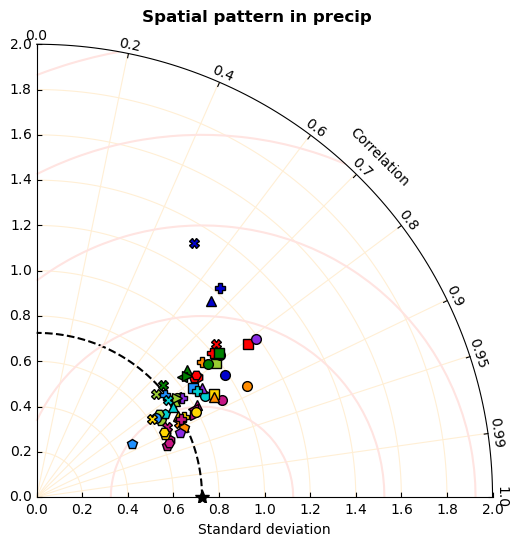

In [48]:
# make Taylor diagram

fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = regridded_cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[0:2])]
    rcm_colour = rcm_colours[mdl.split("_")[-1]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Spatial pattern in "+varnm, fontweight = "bold", y = 0.93)

plt.savefig("fig/taylor-diagram_"+varnm+"_spatial-pattern.png")

---
# **MSWX Wind data**

In [ ]:
mswx_path = "/rds/general/project/wwa/ephemeral/sfcWind/mswx/"

# cut out yearly slices
for y in range(2023, 1978, -1):
    
    new_fnm = mswx_path+"mswx_wind_black-sea_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../00_WWA_project_folder/live/data/mswx/Wind_*/"+str(y)+"*.nc").sel(lon = slice(Xn,Xx), lat = slice(Yx, Yn))
    wrap_lon(da).to_netcdf(new_fnm)

In [ ]:
mswx = xr.open_mfdataset("/rds/general/project/wwa/ephemeral/sfcWind/mswx/*.nc").wind_speed.rename("windspeed")

mswx_sp = mswx.sel(time = slice("1980", "2010")).mean("time")
mswx_sp.to_netcdf("mswx_windspeed_spatial.nc")

mswx_daily = mswx.sel(lon = slice(xn,xx), lat = slice(yn, yx)).mean(["lon", "lat"])

mswx_daily.sel(time = slice("1980", "2010")).groupby("time.dayofyear").mean().to_netcdf("mswx_windspeed_seasonal.nc")

mswx.sel(time = slice("2023-11-26", "2023-11-28")).mean("time").to_netcdf("mswx_windspeed_event.nc")

In [ ]:
# create time series for analysis
mswx_ts = mswx_daily.rolling(time = 3).mean().resample(time = "AS-JUL").max()
mswx_ts = mswx_ts.assign_coords(time = mswx_ts.time.dt.year).rename(time = "year")

csv_fnm = "blacksea-floods_wsx3day_mswx"
csv_fullpath = "/rds/general/project/wwa/ephemeral/sfcWind/ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: MSWX wsx3day - Black Sea flooding 2023, c.barnes22@imperial.ac.uk"
str2 = "# wsx3day [m/s] annual (Jul-Jun) maximum of 3-day mean wind speeds averaged over Black Sea region at "+csv_fnm
head = "# year wsx3day"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
mswx_ts.to_dataframe().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

---
# **Station data**

In [122]:
synop = pd.read_csv("stations/synop.txt", sep = " +", engine = "python", na_values = -9999, parse_dates = ["date"], index_col = ["date"])
stn_pr = synop.loc[slice("2023-11-25", "2023-11-27")].groupby("station").mean()[["precip24h"]]
stn_ws = synop.loc[slice("2023-11-26", "2023-11-28")].groupby("station").mean()[["speed"]]

stn = pd.read_fwf("stations/Stations_desciption", index_col = ["station"])
stn = merge_byindex([stn, stn_pr, stn_ws])
stn = stn.dropna(axis = 0, how = "any")

mswx_wind = xr.open_dataset("mswx_windspeed_event.nc").windspeed
era5_wind = xr.open_dataset("era5_windspeed_event.nc").windspeed

era5_pr = convert_units_to(xr.open_dataset("adaptor.mars.internal-1702905804.0741746-26164-2-90c14ede-0f0b-4b64-968e-b8287c3f8f14.nc").tp.sel(time = slice("2023-11-25", "2023-11-27")).sum("time"), "mm")
mswep_pr = convert_units_to(xr.open_dataset("mswep_precip_event.nc").precip, "mm/day")

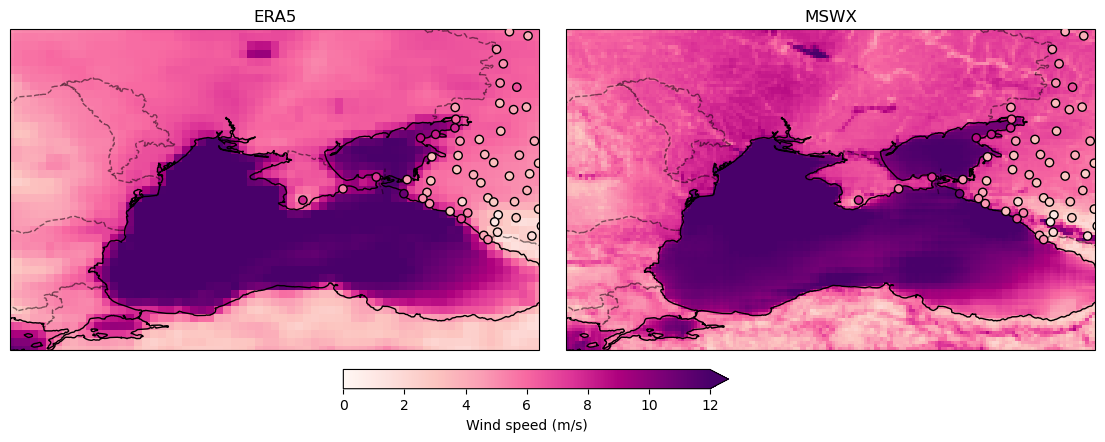

In [93]:
fig, axs = plt.subplots(ncols = 2, figsize = (14,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.05)

plot_kwargs = {"cmap" : "RdPu", "vmin" : 0, "vmax" : 12}

ax = axs[0]
era5_wind.plot(ax = ax, **plot_kwargs, add_colorbar = False)
ax.set_title("ERA5")

ax = axs[1]
cbar = mswx_wind.plot(ax = ax, **plot_kwargs, add_colorbar = False)
ax.set_title("MSWX")

for ax in axs:
    ax.coastlines()
    ax.scatter(stn.lon, stn.lat, marker = "o", edgecolor = "k", c = stn.speed, **plot_kwargs, zorder = 99)
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    
plt.colorbar(cbar, ax = axs, fraction = 0.05, label = "Wind speed (m/s)", location = "bottom", extend = "max", pad = 0.05)

plt.savefig("fig/wind-event.png")

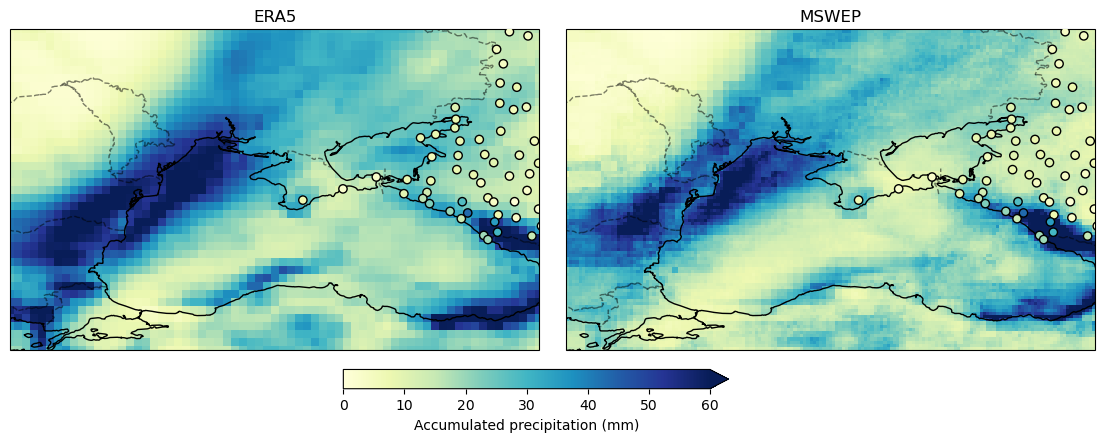

In [126]:
fig, axs = plt.subplots(ncols = 2, figsize = (14,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (xn,xx,yn,yx)})

plt.subplots_adjust(wspace = 0.05)

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 60}

ax = axs[0]
era5_pr.plot(ax = ax, **plot_kwargs, add_colorbar = False)
ax.set_title("ERA5")

ax = axs[1]
cbar = mswep_pr.plot(ax = ax, **plot_kwargs, add_colorbar = False)
ax.set_title("MSWEP")

for ax in axs:
    ax.coastlines()
    ax.scatter(stn.lon, stn.lat, marker = "o", edgecolor = "k", c = stn.precip24h, **plot_kwargs, zorder = 99)
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    
plt.colorbar(cbar, ax = axs, fraction = 0.05, label = "Accumulated precipitation (mm)", location = "bottom", extend = "max", pad = 0.05)

plt.savefig("fig/precip-event.png")

# **Synthesis plots**

In [7]:
varnm = "rx3day_good"

df = {t+"_"+time : pd.read_fwf("synthesis/synth_"+varnm+"_"+t+"_"+time+".txt", comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model") for time in ["past", "proj"] for t in ["pr", "di"]}

int_header = {"rx3day" : "Change in intensity (%)", "wsx3day" : "Change in intensity (m/s)"}[varnm.split("_")[0]]

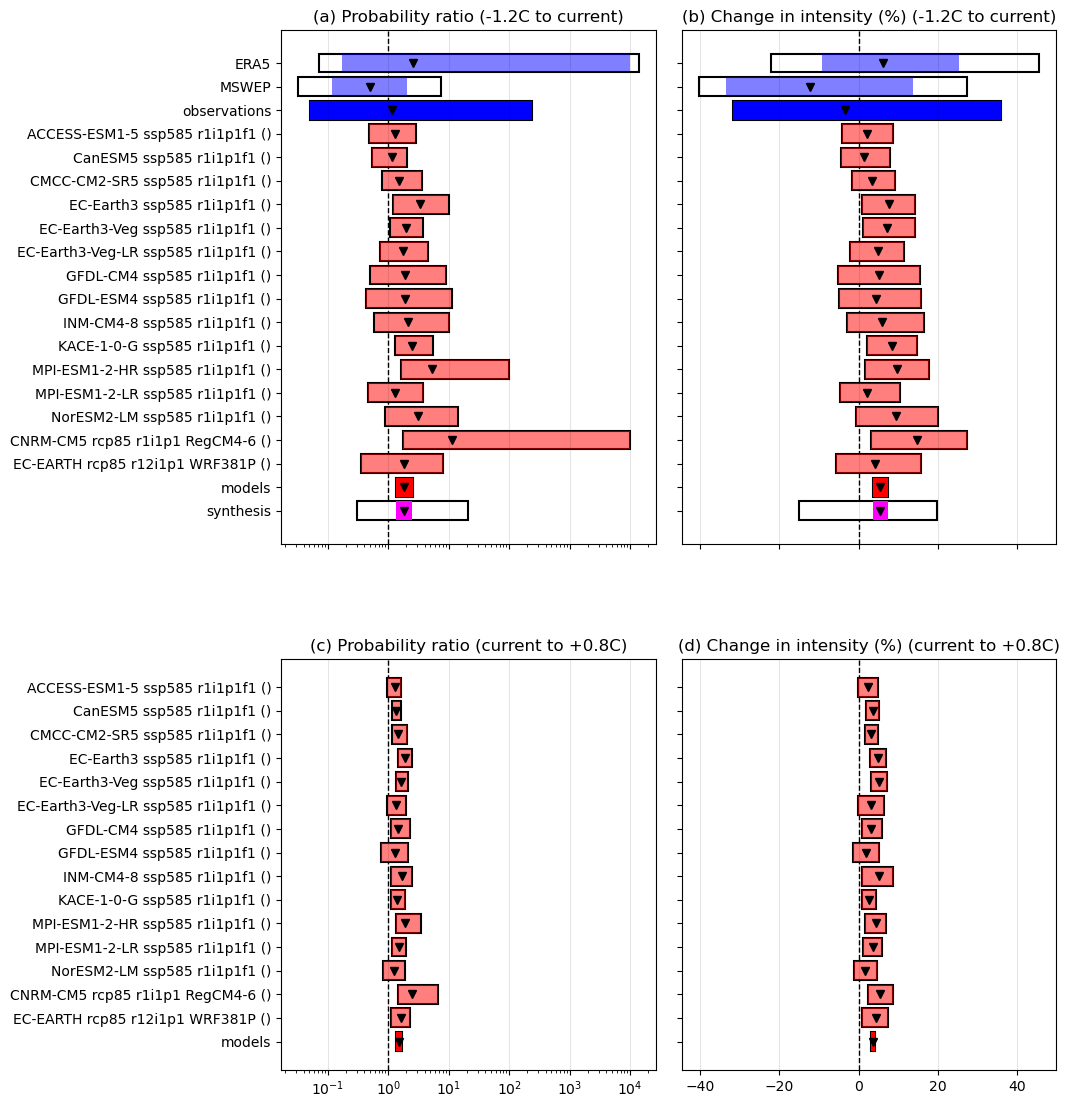

In [8]:
################################################################################################################################################

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,(len(df["di_past"]) + len(df["di_proj"])) * 3/8), dpi = 100,
                        sharey = "row", sharex = "col", gridspec_kw = {"height_ratios" : [len(df["pr_past"]), len(df["pr_proj"])]})
plt.subplots_adjust(wspace = 0.07, hspace = 0.25)

pr_ax = axs[:,0]; di_ax = axs[:,1]

gcols = ["blue", "blue", "red", "red", "magenta"]
galpha = [0.5,1,0.5,1,1]

for ax in pr_ax: ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
for ax in di_ax: ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(2):
    for j in range(2):
        
        ax = axs[i,j]
        ds = ["pr", "di"][j]+"_"+["past", "proj"][i]
        res = df[ds]
        ttl = "("+["a","b","c","d"][i*2+j]+ ") "+["Probability ratio", int_header][j]+" "+["(-1.2C to current)", "(current to +0.8C)"][i]
        
        ax.set_title(ttl)
        
        ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
        
        for k in range(len(res)):
            
            r = res.iloc[k]
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
            ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))

            ax.plot(r.est, -k, color = "k", marker = "v")  
            
axs[0,0].set_xscale('log') 
# axs[1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0,0].set_yticks(range(0, -len(df["pr_past"]), -1))
axs[0,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_past"].index])

axs[1,0].set_yticks(range(0, -len(df["pr_proj"]), -1))
axs[1,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_proj"].index])

plt.savefig("fig/synthesis_"+varnm+".png")